In [1]:
import pandas as pd
from IPython.display import display, Markdown

In [2]:
df = pd.read_csv('data/data_preprocessed.csv')

In [3]:
original_data = pd.read_csv('data/data_resampled.csv')

# Entrenamiento de mejor modelo

Como se encuentra en la exploración de datos, el mejor modelo es un CatBoostClassifier

In [4]:
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split

X = df.drop(columns=['FLAG'])
y = df['FLAG']


x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=23, stratify=y)

model = CatBoostClassifier(random_seed=23, verbose=False)
model.fit(x_train, y_train)

# Resultados del modelo

In [5]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

y_pred = model.predict(x_test)
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print(f'F1 Score: {f1_score(y_test, y_pred)}')
print(f'Precision: {precision_score(y_test, y_pred)}')
print(f'Recall: {recall_score(y_test, y_pred)}')


Accuracy: 0.9966799468791501
F1 Score: 0.9966711051930759
Precision: 0.9993324432576769
Recall: 0.9940239043824701


# Explicación del modelo

In [6]:
data = model.get_feature_importance(prettified=True)
display(data)

,Feature Id,Importances
0,ERC20 most sent token type,26.153274
1,ERC20_most_rec_token_type,15.385787
2,ERC20 uniq rec addr,12.947133
3,Total ERC20 tnxs,10.699098
4,ERC20 min val rec,4.559728
5,ERC20 uniq sent addr,4.448808
6,Time Diff between first and last (Mins),4.311425
7,Unique Received From Addresses,3.434338
8,ERC20 uniq sent token name,3.256748
9,ERC20 avg val rec,2.348959


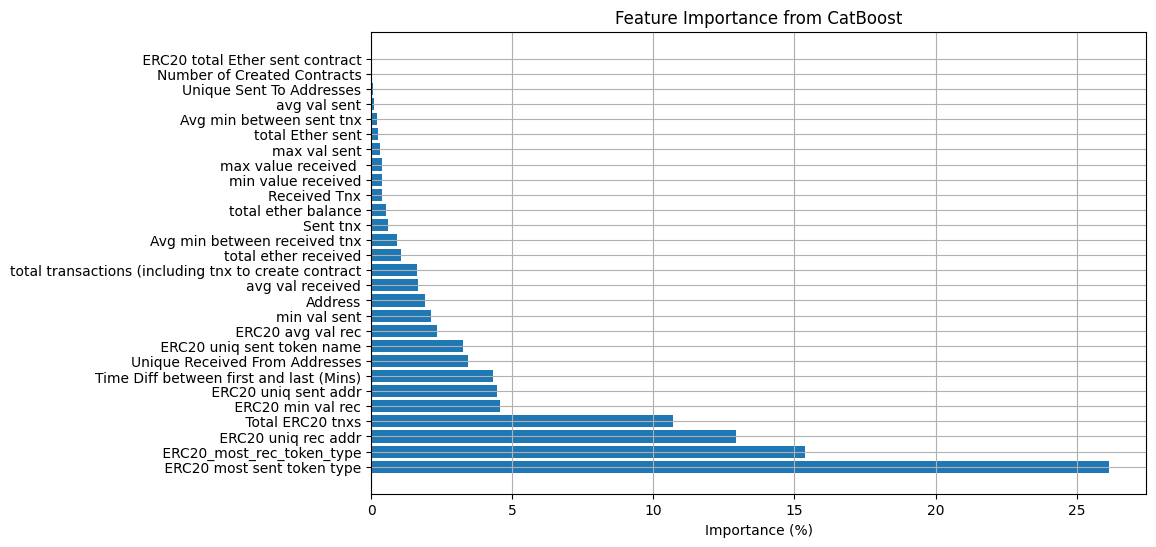

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.barh(data['Feature Id'], data['Importances'])
plt.xlabel('Importance (%)')
plt.title('Feature Importance from CatBoost')
plt.grid()
plt.show()

In [8]:
most_important_features = data.sort_values(by='Importances', ascending=False).head(10)
print("sum of most important features:", most_important_features['Importances'].sum())
most_important_features_names = most_important_features['Feature Id'].tolist()

sum of most important features: 87.5452983514245


Se puede ver que las variables más importantes son:
- `ECR20 most sent token type`: el tipo de token más enviado en la transacción. O la moneda usada en la transacción.
- `ECR20 most received token type`: el tipo de token más recibido en la transacción. O la moneda recibida en la transacción.
- `ECR20 uniq rec addr`: la cantidad de direcciones únicas que recibieron tokens en la transacción.
- `Total ERC20 tnxs`: la cantidad de transacciones.

De esta forma, si conocemos los rangos de las variables, se puede intentar interpretar usando llms.

In [9]:
description = df.describe().T
display(description.head(10))

,count,mean,std,min,25%,50%,75%,max
Address,15056.0,-0.005125,0.568901,-1.017351,-0.495321,0.002924,0.500195,0.896091
Avg min between sent tnx,15056.0,9.383353,41.648932,-0.011945,-0.011945,-0.000172,0.964592,924.435630
Avg min between received tnx,15056.0,1.978908,6.599914,-0.070778,-0.070778,-0.001884,0.933426,164.547048
Time Diff between first and last (Mins),15056.0,0.716690,1.386100,-0.076755,-0.076295,0.000406,0.923688,9.645441
Sent tnx,15056.0,12.448592,101.538718,-0.333333,-0.333333,0.000000,0.500000,1666.333333
Received Tnx,15056.0,6.473190,45.254247,-0.235294,-0.176471,0.000000,0.823529,588.000000
Number of Created Contracts,15056.0,2.455300,114.366238,0.000000,0.000000,0.000000,0.000000,9995.000000
Unique Received From Addresses,15056.0,3.501184,40.638366,-0.500000,-0.333333,-0.166667,0.666667,1666.000000
Unique Sent To Addresses,15056.0,5.640852,71.224679,-0.333333,-0.333333,0.000000,0.666667,3095.333333
min value received,15056.0,68.925530,726.377655,-0.087136,-0.086963,-0.000693,0.884051,17254.108437


In [25]:
most_important_description = description.loc[most_important_features_names]
# most_important_description = description

Se convierten a un json para poder usarlo en el llm

In [11]:
most_important_description_json = most_important_description.to_json(orient='index')
most_important_features_json = most_important_features.to_json(orient='index')

In [18]:
system_prompt = """
# Descripción del problema:

Eres un experto en análisis de datos y modelos de machine learning.
Tu tarea es interpretar los resultados de un modelo de machine learning y explicar qué significa cada variable en el contexto del problema.
Te daré una descripción de las variables más importantes del modelo y su rango.
Usa esta información para explicar qué significa cada variable y cómo se relaciona con el problema que estamos tratando de resolver.
Ten en cuenta que las variables son numéricas y representan diferentes aspectos de las transacciones de criptomonedas en especial Ethereum.
La variable objetivo es `FLAG`, que indica si una transacción es fraude o no. Dicha variable es evaluada por el modelo y se usa para predecir si una transacción es fraudulenta o no.
Las variables están normalizadas mediante un robust scaler.
Debes responder en español

Aquí tienes la descripción de las variables más importantes del modelo ten en cuenta que fueron filtradas por su importancia en el modelo y que son las más relevantes para la predicción de fraude:
{most_important_description_json}
Y aquí tienes la importancia de las variables en porcentaje:
{most_important_features_json}

# Explicación de las variables:

Index: the index number of a row
Address: the address of the ethereum account
FLAG: whether the transaction is fraud or not
Avg min between sent tnx: Average time between sent transactions for account in minutes
Avg_min_between_received_tnx: Average time between received transactions for account in minutes
Time_Diff_between_first_and_last(Mins): Time difference between the first and last transaction
Sent_tnx: Total number of sent normal transactions
Received_tnx: Total number of received normal transactions
Number_of_Created_Contracts: Total Number of created contract transactions
Unique_Received_From_Addresses: Total Unique addresses from which account received transactions
Unique_Sent_To_Addresses20: Total Unique addresses from which account sent transactions
Min_Value_Received: Minimum value in Ether ever received
Max_Value_Received: Maximum value in Ether ever received
Avg_Value_Received5Average value in Ether ever received
Min_Val_Sent: Minimum value of Ether ever sent
Max_Val_Sent: Maximum value of Ether ever sent
Avg_Val_Sent: Average value of Ether ever sent
Min_Value_Sent_To_Contract: Minimum value of Ether sent to a contract
Max_Value_Sent_To_Contract: Maximum value of Ether sent to a contract
Avg_Value_Sent_To_Contract: Average value of Ether sent to contracts
Total_Transactions(Including_Tnx_to_Create_Contract): Total number of transactions
Total_Ether_Sent:Total Ether sent for account address
Total_Ether_Received: Total Ether received for account address
Total_Ether_Sent_Contracts: Total Ether sent to Contract addresses
Total_Ether_Balance: Total Ether Balance following enacted transactions
Total_ERC20_Tnxs: Total number of ERC20 token transfer transactions
ERC20_Total_Ether_Received: Total ERC20 token received transactions in Ether
ERC20_Total_Ether_Sent: Total ERC20token sent transactions in Ether
ERC20_Total_Ether_Sent_Contract: Total ERC20 token transfer to other contracts in Ether
ERC20_Uniq_Sent_Addr: Number of ERC20 token transactions sent to Unique account addresses
ERC20_Uniq_Rec_Addr: Number of ERC20 token transactions received from Unique addresses
ERC20_Uniq_Rec_Contract_Addr: Number of ERC20token transactions received from Unique contract addresses
ERC20_Avg_Time_Between_Sent_Tnx: Average time between ERC20 token sent transactions in minutes
ERC20_Avg_Time_Between_Rec_Tnx: Average time between ERC20 token received transactions in minutes
ERC20_Avg_Time_Between_Contract_Tnx: Average time ERC20 token between sent token transactions
ERC20_Min_Val_Rec: Minimum value in Ether received from ERC20 token transactions for account
ERC20_Max_Val_Rec: Maximum value in Ether received from ERC20 token transactions for account
ERC20_Avg_Val_Rec: Average value in Ether received from ERC20 token transactions for account
ERC20_Min_Val_Sent: Minimum value in Ether sent from ERC20 token transactions for account
ERC20_Max_Val_Sent: Maximum value in Ether sent from ERC20 token transactions for account
ERC20_Avg_Val_Sent: Average value in Ether sent from ERC20 token transactions for account
ERC20_Uniq_Sent_Token_Name: Number of Unique ERC20 tokens transferred
ERC20_Uniq_Rec_Token_Name: Number of Unique ERC20 tokens received
ERC20_Most_Sent_Token_Type: Most sent token for account via ERC20 transaction
ERC20_Most_Rec_Token_Type: Most received token for account via ERC20 transactions

# Ejemplo de uso:

El usuario te dará las variables transformadas y originales de la forma:

{{
  "variables_transformadas": {{...}},
    "variables_originales": {{...}}
}}

# Restricciones:

Debes responder en markdown y usar secciones para explicarte mejor.
Debes ser consisto y claro en tus explicaciones.
Al finalizar debes aportar un resumen de la información.
Debes responder en base a la información brindada por el usuario.



"""

In [21]:
true_data = y_pred == 1
false_data = y_pred == 0

true_data_df = x_test[true_data]
false_data_df = x_test[false_data]

example_true = true_data_df.sample(50)
example_false = false_data_df.sample(50)

example_true_json = example_true.to_dict(orient='index')
example_false_json = example_false.to_dict(orient='index')

original_true = original_data.loc[example_true.index]
original_false = original_data.loc[example_false.index]

original_true_json = original_true.to_dict(orient='index')
original_false_json = original_false.to_dict(orient='index')

example_true_json = [[index, data] for index, data in zip(example_true_json.values(), original_true_json.values())]
example_false_json = [[index, data] for index, data in zip(example_false_json.values(), original_false_json.values())]

for data in example_true_json:
    data[0]['FLAG'] = 1
    assert data[1]['FLAG'] == 1

for data in example_false_json:
    data[0]['FLAG'] = 0
    assert data[1]['FLAG'] == 0

prompts_example = [str({"variables_transformadas": data[0], "variables_originales": data[1]}) for data in example_true_json + example_false_json]

In [24]:
prompts_df = pd.DataFrame(prompts_example, columns=['prompt'])
prompts_df.to_csv('data/prompts_example.csv', index=False)

system_prompt_to_save = system_prompt.format(
    most_important_description_json=most_important_description_json,
    most_important_features_json=most_important_features_json
)
with open('data/system_prompt.txt', 'w', encoding="utf-8") as f:
    f.write(system_prompt_to_save)

In [19]:
from langchain_ollama import ChatOllama

model = ChatOllama(
    model="qwen3:14b",
    temperature=0.0
)

messages = [
    {"role": "system", "content": system_prompt.format(
        most_important_description_json=most_important_description_json,
        most_important_features_json=most_important_features_json
    )},
    {"role": "user", "content": prompts_example[0]}
]

test_response = model.invoke(messages)


In [20]:
def get_response_thinking(message)-> str:

    content = message.content
    content = content.split("</think>")[1]
    return content

test_response_thinking = get_response_thinking(test_response)
display(Markdown(test_response_thinking))



# Análisis de Variables Transformadas y Originales

## Variables Transformadas con Mayor Relevancia

### 1. **ERC20_most_rec_token_type**  
- **Valor transformado:** -0.1268  
- **Valor original:** "Blockwell say NOTSAFU"  
- **Interpretación:**  
  - El valor transformado está por debajo de la mediana (0), lo que sugiere que este token no es común en transacciones legítimas.  
  - El nombre del token ("Blockwell say NOTSAFU") parece ser un token específico o no reconocido, lo que podría indicar una actividad sospechosa.  
  - **Relación con FLAG:** Este token podría estar asociado a transacciones fraudulentas si no se encuentra en registros de tokens legítimos.

---

### 2. **ERC20_most_sent_token_type**  
- **Valor transformado:** -0.0101  
- **Valor original:** " " (vacio)  
- **Interpretación:**  
  - El valor transformado está muy cercano a la mediana (0), pero el valor original es un campo vacío.  
  - Esto podría indicar una falta de información o un token no registrado, lo que podría ser un indicador de transacciones anómalas.  
  - **Relación con FLAG:** La ausencia de datos en este campo podría ser un factor de riesgo para el modelo.

---

### 3. **ERC20_uniq_rec_addr**  
- **Valor transformado:** 1.56  
- **Valor original:** 4.0  
- **Interpretación:**  
  - El valor transformado está por encima de la mediana (0), lo que sugiere que la cuenta recibió transacciones de múltiples direcciones únicas.  
  - **Relación con FLAG:** Recibir de 4 direcciones únicas (valor original) podría ser un patrón común en transacciones fraudulentas, especialmente si estas direcciones no tienen historial previo.  

---

### 4. **Total ERC20 tnxs**  
- **Valor transformado:** 2.0  
- **Valor original:** 5.0  
- **Interpretación:**  
  - El valor transformado está por encima de la mediana (0), lo que indica un número de transacciones ERC20 más alto que lo típico.  
  - **Relación con FLAG:** 5 transacciones ERC20 (valor original) podrían ser normales, pero en combinación con otros factores (como el token recibido) podrían ser sospechosas.

---

### 5. **Time Diff between first and last (Mins)**  
- **Valor transformado:** 1.14  
- **Valor original:** 245518.5 minutos (~173 días)  
- **Interpretación:**  
  - El valor transformado está por encima de la mediana (0), lo que sugiere un período de inactividad prolongado.  
  - **Relación con FLAG:** Una inactividad de 173 días seguida de una transacción podría indicar una cuenta "dormida" reactivada, un patrón común en fraudes.

---

### 6. **Unique Received From Addresses**  
- **Valor transformado:** 4.67  
- **Valor original:** 31  
- **Interpretación:**  
  - El valor transformado está muy por encima de la mediana (0), lo que indica una gran cantidad de direcciones únicas que han enviado transacciones a esta cuenta.  
  - **Relación con FLAG:** Recibir de 31 direcciones únicas (valor original) es altamente inusual y podría ser un indicador de lavado de dinero o fraude.

---

## Variables con Valor Original Anómalo

### 1. **Avg val sent**  
- **Valor transformado:** 4.67  
- **Valor original:** 49.003094  
- **Interpretación:**  
  - El valor transformado está por encima de la mediana (0), lo que sugiere un monto de envío elevado.  
  - **Relación con FLAG:** Enviar 49.003094 ETH (valor original) en una sola transacción podría ser un indicador de transacciones de alto valor, común en fraudes o lavado de dinero.

---

## Resumen de la Información

- **FLAG = 1 (fraude):** La cuenta fue marcada como fraudulenta debido a una combinación de factores:  
  - **Recepción de transacciones desde múltiples direcciones únicas** (31 direcciones).  
  - **Uso de un token no reconocido** ("Blockwell say NOTSAFU").  
  - **Inactividad prolongada** (173 días) seguida de una transacción.  
  - **Envío de un monto elevado** (49.003094 ETH).  
  - **Falta de información en el token más enviado** (campo vacío).  

- **Variables clave:**  
  - **ERC20_most_rec_token_type** y **ERC20_uniq_rec_addr** son las variables con mayor peso en la decisión del modelo.  
  - La **inactividad prolongada** y el **alto volumen de transacciones** también contribuyeron al flagging.  

- **Recomendación:**  
  - Verificar si el token "Blockwell say NOTSAFU" es legítimo.  
  - Analizar el historial de las 31 direcciones que enviaron transacciones a esta cuenta.  
  - Revisar si el monto de 49.003094 ETH es coherente con el patrón de transacciones de la cuenta.